In [1]:
# Importing modules to access and visualise data
import xarray as xr # used for netcdf and h5 files, climate data
import h5py
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfea
import pyproj
import datetime
from scipy.interpolate import griddata
from scipy.stats import binned_statistic_2d
import os, sys
from matplotlib.colors import LinearSegmentedColormap


In [2]:
def WGS84toEASE2N(lon, lat):
    '''Converts WGS84 coordinates to EASE2N.

    Params:
        lon (array): the WGS84 longitude to convert
        lat (array): the WGS84 latitude to convert

    Returns:
        (x, y): the corresponding EASE2N x and y coordinates
    '''

    proj_EASE2N = pyproj.Proj("+proj=laea +lon_0=0 +lat_0=90 +x_0=0 +y_0=0 +ellps=WGS84 +towgs84=0,0,0,0,0,0,0 +units=m +no_defs")
    proj_WGS84 = pyproj.Proj("+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs ")
    return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


def LOAD_MISR(MISR_path):
    '''Loads MISR data and coordinates from specified file path.

    Params:
        MISR_path (str): the file path from which to retrieve data

    Returns:
        data (np.array): roughness data retrieved from the specified file
        lon, lat
        x, y
    '''

    file = h5py.File(MISR_path, 'r')
    
    # extract coord data
    lon = np.array(file['GeoLocation']['Longitude'])
    lat = np.array(file['GeoLocation']['Latitude'])
    x = np.array(file['GeoLocation']['x'])
    y = np.array(file['GeoLocation']['y'])

    # extract roughness data
    data = np.array(file['Roughness']['Roughness_2D_svm'])    
    
    file.close()

    return data, lon, lat, x, y


def LOAD_MPF(MPF_path): # Loads data from Sangyun Lee dataset on CPOM servers, just for month of JULY
    '''Loads MPF data for individual months and calculates the pixel-by-pixel mean across all months.

    Params:
        MPF_path (str): the file path from which data will be retrieved

    Returns:
        mean, may, june, july, aug: numpy arrays for the mean and individual months
    '''
    ds = xr.open_dataset(MPF_path)

    # retrieve data for individual months
    may = np.array(ds['may_monthly'])
    june = np.array(ds['june_monthly'])
    july = np.array(ds['july_monthly'])
    aug = np.array(ds['august_monthly'])
 
    # calculate mean over all months
    mean = np.nanmean(np.array([may, june, july, aug]), 0)

    return mean, may, june, july, aug


def MPF_UCL_COORDS(MPF_coords_path): # reads coordinate data from sangyun lee mpf data set
    '''
    Retrieves grid coordinates for MPF data.
    
    Params:
        MPF_coords_path (str): the file path from which the coordinates will be retrieved
        
    Returns:
        lon, lat
    '''
    ds = xr.open_dataset(MPF_coords_path)
    lon = np.asarray(ds['mp_lon'])
    lat = np.asarray(ds['mp_lat'])
        
    return lon, lat


def MASK_MPF_MISR(mpf_MISRGRID, MISR):
    # Create masks for valid data in each array
    mask1 = ~np.isnan(mpf_MISRGRID)  # Invert the NaN values to get a mask of valid data
    mask2 = ~np.isnan(MISR)

    # Create a joint mask where both arrays have valid data
    joint_mask = mask1 & mask2

    # Use the joint mask to apply the mask to both arrays and corresponding latitude
    masked_MPF_MISRGRID = np.ma.masked_array(mpf_MISRGRID, mask=~joint_mask)
    masked_MISR = np.ma.masked_array(MISR, mask=~joint_mask)
    masked_lat_MISR = np.ma.masked_array(lat_MISR, mask=~joint_mask)

    return masked_MPF_MISRGRID, masked_MISR, masked_lat_MISR


def interpolate_to_MISR(x_in, y_in, data, x_out, y_out):
    '''
    Interpolates data of the shape X_in, Y_in to the shape of X_out, Y_out.
    
    Params:
        data: the data to be interpolated
        x_in, y_in: the shape of the data to be interpolated
        
    Returns:
        x_out, y_out: the shape to which the data will be interpolated'''
    return griddata((x_in.ravel(), y_in.ravel()), data.ravel( ), (x_out.ravel(), y_out.ravel()), 'nearest').reshape(8000,8000) 


def predict_mpf(SIR, R0, l, tau, hnet):
    '''
    Predicts meltpond fraction given an input SIR, based on the model by Landy et al, 2015.
    '''
    R = R0 * np.exp(-l * SIR) + tau
    return (1 - np.exp(-R * hnet))


In [3]:
! echo "April sea ice roughness years available:"
! ls /home/ssureen/MISR_data_monthly/
! echo "Melt pond fraction years available (May-August):"
! ls /home/sl/melt_pond/data

April sea ice roughness years available:
April 2000 Roughness.h5  April 2007 Roughness.h5  April 2014 Roughness.h5
April 2001 Roughness.h5  April 2008 Roughness.h5  April 2015 Roughness.h5
April 2002 Roughness.h5  April 2009 Roughness.h5  April 2016 Roughness.h5
April 2003 Roughness.h5  April 2010 Roughness.h5  April 2017 Roughness.h5
April 2004 Roughness.h5  April 2011 Roughness.h5  April 2018 Roughness.h5
April 2005 Roughness.h5  April 2012 Roughness.h5  April 2019 Roughness.h5
April 2006 Roughness.h5  April 2013 Roughness.h5  April 2020 Roughness.h5
Melt pond fraction years available (May-August):
2000  2003  2006  2009	2012  2015  2018  2021
2001  2004  2007  2010	2013  2016  2019  2022
2002  2005  2008  2011	2014  2017  2020  mp_coordinate.nc


In [11]:
YEAR = 2003

# retrieve MISR data for given year
MISR_path = f'/home/ssureen/MISR_data_monthly/April {YEAR} Roughness.h5'
MISR, lon_MISR, lat_MISR, x_MISR, y_MISR = LOAD_MISR(MISR_path)


/tmp/ipykernel_306482/1741789577.py:14: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)
/tmp/ipykernel_306482/1741789577.py:63: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(np.array([may, june, july, aug]), 0)


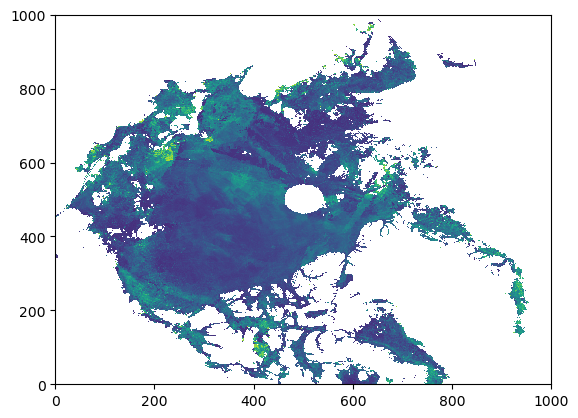

In [12]:
# retrieve MPF coordinates and convert to EASE grid for comparison
lon_MPF, lat_MPF = MPF_UCL_COORDS('/home/sl/melt_pond/data/mp_coordinate.nc')
x_MPF, y_MPF = WGS84toEASE2N(lon_MPF, lat_MPF)

# retrieve MPF data for given year
mpf_path = f'/home/sl/melt_pond/data/{YEAR}/MODIS_Meltpond_Fraction_CPOM_5km_monthly_{YEAR}.nc'
mpf_mean, mpf_may, mpf_june, mpf_july, mpf_aug = LOAD_MPF(mpf_path)

plt.pcolormesh(mpf_june)


In [13]:
# interpolate MPF to MISR grid for each month and mean for the year

mpf_mean_MISRGRID = interpolate_to_MISR(x_MPF, y_MPF, mpf_mean ,x_MISR, y_MISR )
masked_MPF_mean_MISRGRID, masked_mean_MISR, masked_lat_mean_MISR = MASK_MPF_MISR(mpf_mean_MISRGRID, MISR)

mpf_may_MISRGRID = interpolate_to_MISR(x_MPF, y_MPF, mpf_may ,x_MISR, y_MISR )
masked_MPF_may_MISRGRID, masked_may_MISR, masked_lat_may_MISR = MASK_MPF_MISR(mpf_may_MISRGRID, MISR)

mpf_june_MISRGRID = interpolate_to_MISR(x_MPF, y_MPF, mpf_june ,x_MISR, y_MISR )
masked_MPF_june_MISRGRID, masked_june_MISR, masked_lat_june_MISR = MASK_MPF_MISR(mpf_june_MISRGRID, MISR)

mpf_july_MISRGRID = interpolate_to_MISR(x_MPF, y_MPF, mpf_july ,x_MISR, y_MISR )
masked_MPF_july_MISRGRID, masked_july_MISR, masked_lat_july_MISR = MASK_MPF_MISR(mpf_july_MISRGRID, MISR)

mpf_aug_MISRGRID = interpolate_to_MISR(x_MPF, y_MPF, mpf_aug ,x_MISR, y_MISR )
masked_MPF_aug_MISRGRID, masked_aug_MISR, masked_lat_aug_MISR = MASK_MPF_MISR(mpf_aug_MISRGRID, MISR)


In [ ]:
# predict MPF using constants provided by Landy et al, 2015

R0 = 65.43
L = 16.14
TAU = 5.15
HNET = 0.025    # hnet between 20 and 40mm from Landy, in metres??

pred_mpf = predict_mpf(MISR, R0, L, TAU, HNET)

# to find the overlap - gives only the points that exist in both sets
mpf_overlap = mpf_mean_MISRGRID + (0 * pred_mpf)
pred_overlap = pred_mpf + (0 * mpf_mean_MISRGRID)


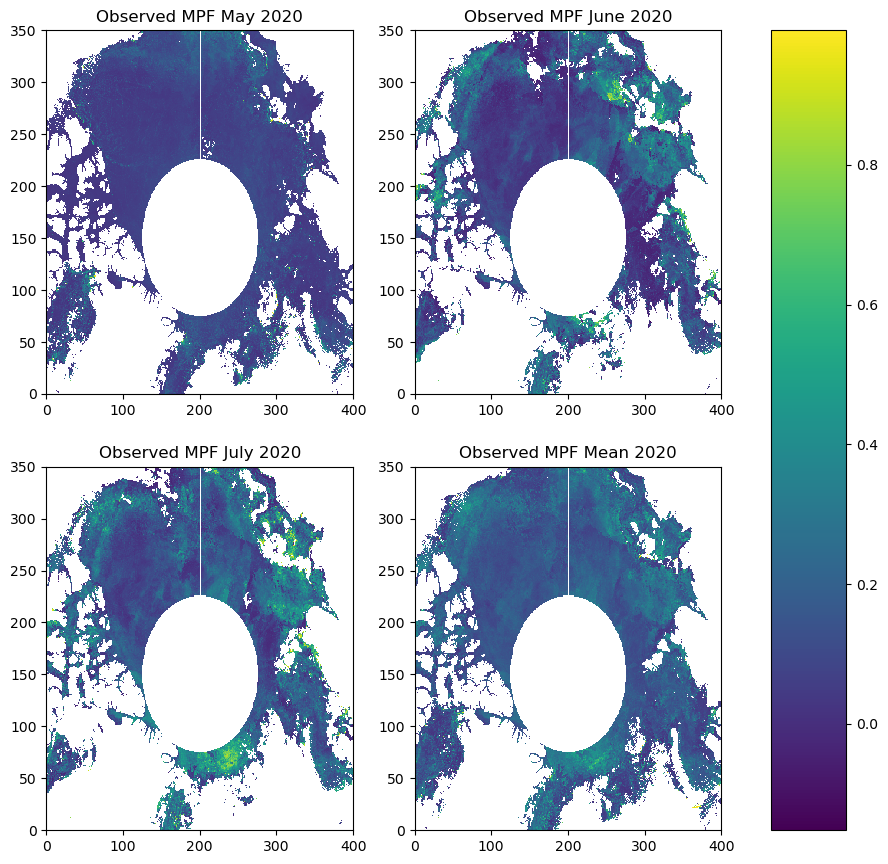

In [14]:
fig = plt.figure(figsize=(10,10))

plt.subplot(221)
plt.pcolormesh(masked_MPF_may_MISRGRID[2500:6000:10, 2000:6000:10])
plt.title('Observed MPF May 2020')

plt.subplot(222)
plt.pcolormesh(masked_MPF_june_MISRGRID[2500:6000:10, 2000:6000:10])
plt.title('Observed MPF June 2020')

plt.subplot(223)
plt.pcolormesh(masked_MPF_july_MISRGRID[2500:6000:10, 2000:6000:10])
plt.title('Observed MPF July 2020')

plt.subplot(224)
plt.pcolormesh(masked_MPF_mean_MISRGRID[2500:6000:10, 2000:6000:10])
plt.title('Observed MPF Mean 2020')

plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
cax = plt.axes((0.85, 0.1, 0.075, 0.8))
plt.colorbar(cax=cax)

YEAR=2020
plt.savefig(f'MPF_figs/MPF_{YEAR}.svg', format='svg')

In [9]:
years = os.listdir(f'/home/sl/melt_pond/data')
years.remove('mp_coordinate.nc')

# retrieve MPF coordinates and convert to EASE grid for comparison
try:
    lon_MPF, lat_MPF = MPF_UCL_COORDS('/home/sl/melt_pond/data/mp_coordinate.nc')
    x_MPF, y_MPF = WGS84toEASE2N(lon_MPF, lat_MPF)
    print(f'Coordinates successfully retrieved.')
except:
    print(f'Coordinates could not be retrieved.')

for year in years:
    # retrieve MISR data for given year
    try:
        MISR_path = f'/home/ssureen/MISR_data_monthly/April {year} Roughness.h5'
        MISR, lon_MISR, lat_MISR, x_MISR, y_MISR = LOAD_MISR(MISR_path)
        print(f'Succesfully retrieved data from {MISR_path}.')
    except:
        print(f'MISR data could not be retrieved from {MISR_path}.')
    
    # retrieve MPF data for given year
    try:
        mpf_path = f'/home/sl/melt_pond/data/2020/MODIS_Meltpond_Fraction_CPOM_5km_monthly_{year}.nc'
        mpf_mean, mpf_may, mpf_june, mpf_july, mpf_aug = LOAD_MPF(mpf_path)
        print(f'Successfully retrieved data from {mpf_path}.')
    except:
        print(f'MPF data could not be retrieved from {mpf_path}.')

    try:
        # interpolate MPF to MISR grid for each month and mean for the year
        mpf_mean_MISRGRID = interpolate_to_MISR(x_MPF, y_MPF, mpf_mean ,x_MISR, y_MISR )
        masked_MPF_mean_MISRGRID, masked_mean_MISR, masked_lat_mean_MISR = MASK_MPF_MISR(mpf_mean_MISRGRID, MISR)

        mpf_may_MISRGRID = interpolate_to_MISR(x_MPF, y_MPF, mpf_may ,x_MISR, y_MISR )
        masked_MPF_may_MISRGRID, masked_may_MISR, masked_lat_may_MISR = MASK_MPF_MISR(mpf_may_MISRGRID, MISR)

        mpf_june_MISRGRID = interpolate_to_MISR(x_MPF, y_MPF, mpf_june ,x_MISR, y_MISR )
        masked_MPF_june_MISRGRID, masked_june_MISR, masked_lat_june_MISR = MASK_MPF_MISR(mpf_june_MISRGRID, MISR)

        mpf_july_MISRGRID = interpolate_to_MISR(x_MPF, y_MPF, mpf_july ,x_MISR, y_MISR )
        masked_MPF_july_MISRGRID, masked_july_MISR, masked_lat_july_MISR = MASK_MPF_MISR(mpf_july_MISRGRID, MISR)

        mpf_aug_MISRGRID = interpolate_to_MISR(x_MPF, y_MPF, mpf_aug ,x_MISR, y_MISR )
        masked_MPF_aug_MISRGRID, masked_aug_MISR, masked_lat_aug_MISR = MASK_MPF_MISR(mpf_aug_MISRGRID, MISR)

        print(f'Succesfully interpolated all months.')
    except:
        print(f'Could not interpolate data.')

    fig = plt.figure(figsize=(10,10))

    plt.subplot(221)
    plt.pcolormesh(mpf_may_MISRGRID[2500:6000:10, 2000:6000:10])
    plt.title('Observed MPF May 2020')

    plt.subplot(222)
    plt.pcolormesh(mpf_june_MISRGRID[2500:6000:10, 2000:6000:10])
    plt.title('Observed MPF June 2020')

    plt.subplot(223)
    plt.pcolormesh(mpf_july_MISRGRID[2500:6000:10, 2000:6000:10])
    plt.title('Observed MPF July 2020')

    plt.subplot(224)
    plt.pcolormesh(mpf_mean_MISRGRID[2500:6000:10, 2000:6000:10])
    plt.title('Observed MPF Mean 2020')

    plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
    cax = plt.axes((0.85, 0.1, 0.075, 0.8))
    plt.colorbar(cax=cax)

    try:
        fig_fn = f'MPF_{year}'
        plt.savefig(fig_fn, format='svg')
        print(f'Figure saved as {fig_fn}.')
    except:
        print(f'{year} figure could not be saved.')


The year is 2001
The year is 2002
The year is 2003
The year is 2004
The year is 2005
The year is 2006
The year is 2007
The year is 2008
The year is 2009
The year is 2010
The year is 2011
The year is 2012
The year is 2013
The year is 2014
The year is 2015
The year is 2016
The year is 2017
The year is 2018
The year is 2019
The year is 2020
The year is 2021
The year is 2022
The year is 2000


In [ ]:
# plot and save figures as above for all MPF years.

YEARS = [2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010,]

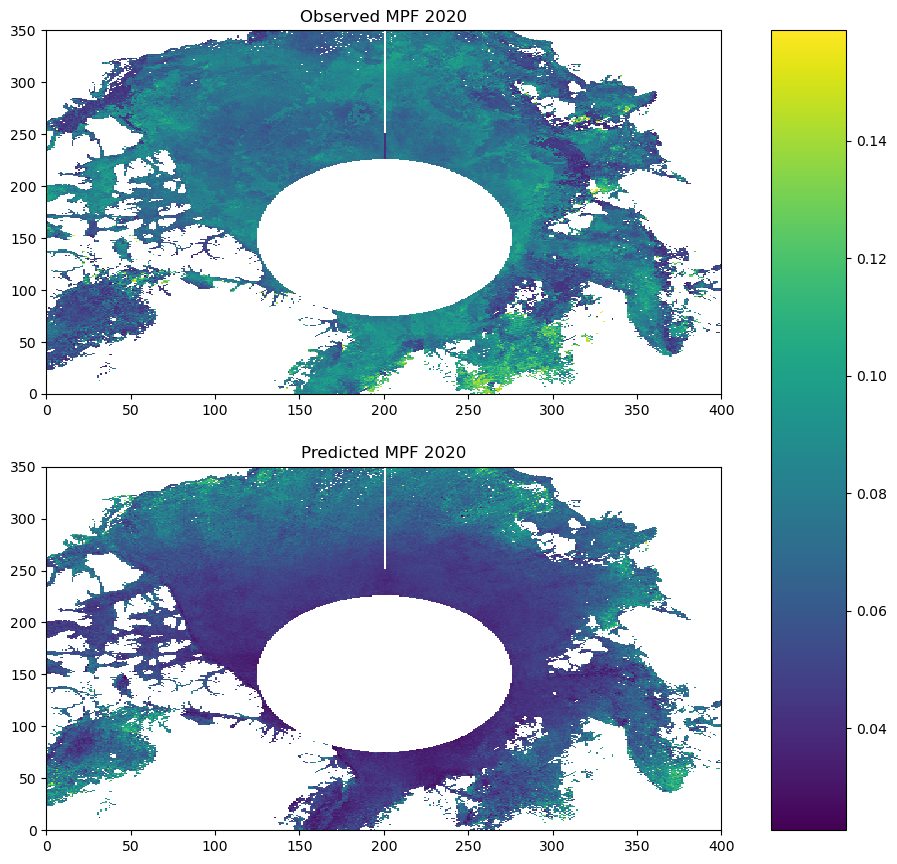

In [29]:
fig = plt.figure(figsize=(10,10))

plt.subplot(211)
plt.pcolormesh(mpf_overlap[2500:6000:10, 2000:6000:10])
plt.title('Observed MPF 2020')

plt.subplot(212)
plt.pcolormesh(pred_overlap[2500:6000:10, 2000:6000:10])
plt.title('Predicted MPF 2020')

plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
cax = plt.axes((0.85, 0.1, 0.075, 0.8))
plt.colorbar(cax=cax)

plt.show()

In [ ]:
lon = lon_MISR[2500:6000, 2000:6000]
lat = lat_MISR[2500:6000, 2000:6000]
data = mpf_overlap[2500:6000, 2000:6000]

projection = ccrs.RotatedPole(pole_longitude=-177.5, pole_latitude=37.5)
ax = plt.axes(projection=projection)
#ax.set_global()
ax.coastlines()
ax.contourf(lon, lat, data, transform=ccrs.PlateCarree())
ax.set_title('MPF 2020')


: 

RuntimeError: No mappable was found to use for colorbar creation. First define a mappable such as an image (with imshow) or a contour set (with contourf).

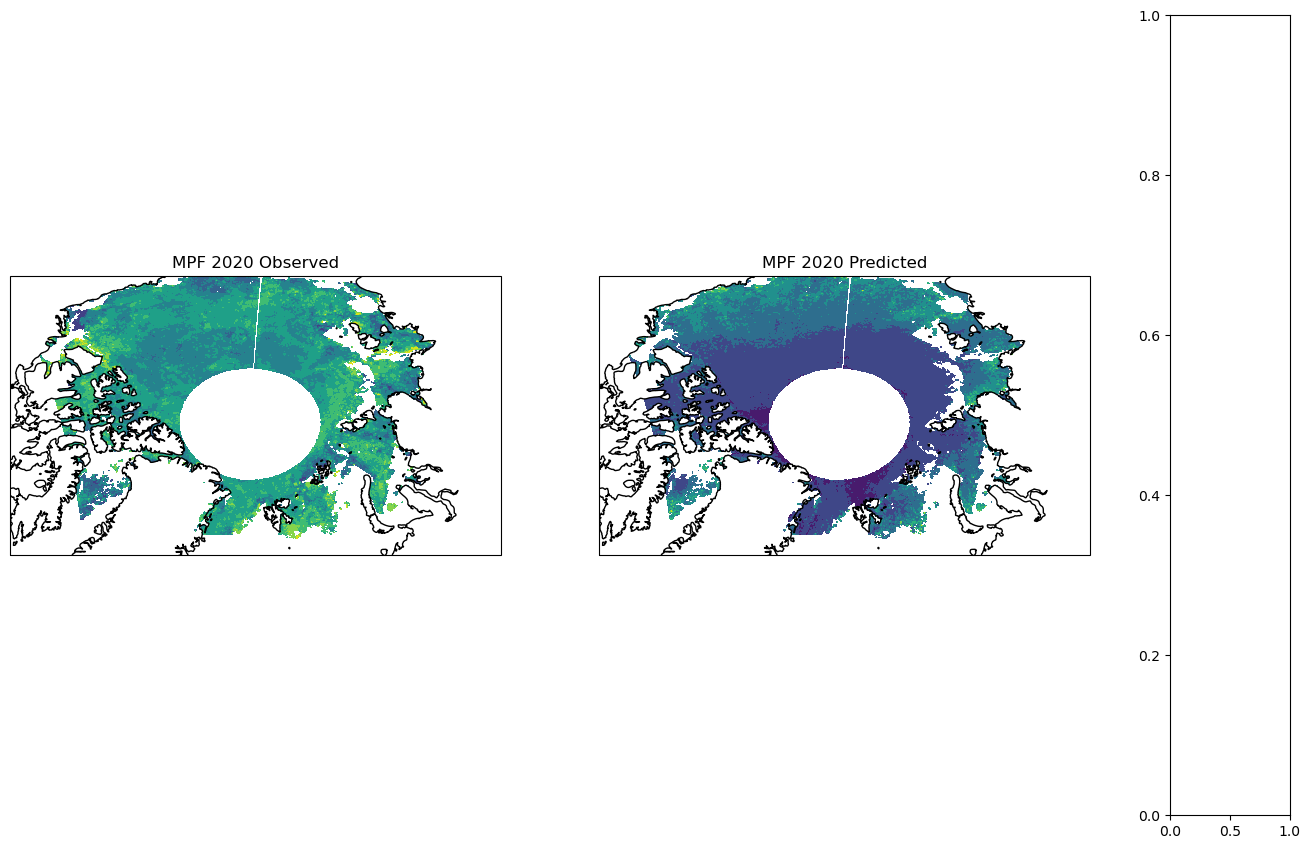

In [7]:
lon = lon_MISR[2500:6000:10, 2000:6000:10]
lat = lat_MISR[2500:6000:10, 2000:6000:10]
observed = mpf_overlap[2500:6000:10, 2000:6000:10]
pred = pred_overlap[2500:6000:10, 2000:6000:10]

projection = ccrs.RotatedPole(pole_longitude=-177.5, pole_latitude=37.5)
fig = plt.figure(figsize=(16,10))

ax1 = fig.add_subplot(121, projection=projection)
ax1.coastlines()
ax1.contourf(lon, lat, observed, transform=ccrs.PlateCarree())
ax1.set_title('MPF 2020 Observed')

ax2 = fig.add_subplot(122, projection=projection)
ax2.coastlines()
ax2.contourf(lon, lat, pred, transform=ccrs.PlateCarree())
ax2.set_title('MPF 2020 Predicted')

plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
cax = plt.axes((0.85, 0.1, 0.075, 0.8))
plt.colorbar(cax=cax)

